In [37]:
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

train = pd.read_csv(r"/content/sample_data/train.csv")
test = pd.read_csv(r"/content/sample_data/test.csv")

class DataFrameImputer(TransformerMixin):
    def __init__(self):
        self.fill = None
        self.label_encoders = {}

    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
                               if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
                              index=X.columns)

        for col in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le

        return self

    def transform(self, X, y=None):
        X = X.fillna(self.fill)

        for col, le in self.label_encoders.items():
            X[col] = le.transform(X[col])

        return X

continuous_features = train.select_dtypes(exclude=['O'])
categorical_features = train.select_dtypes(include=['O'])

train = DataFrameImputer().fit_transform(train)
test = DataFrameImputer().fit_transform(test)

X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train)
print(y_train)

print(X_val)
print(y_val)

print(X_train.shape)
print(X_val.shape)


        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
254    255          20         3         70.0     8400       1      0   
1066  1067          60         3         59.0     7837       1      0   
638    639          30         3         67.0     8777       1      0   
799    800          50         3         60.0     7200       1      0   
380    381          50         3         50.0     5000       1      1   
...    ...         ...       ...          ...      ...     ...    ...   
1095  1096          20         3         78.0     9317       1      0   
1130  1131          50         3         65.0     7804       1      0   
1294  1295          20         3         60.0     8172       1      0   
860    861          50         3         55.0     7642       1      0   
1126  1127         120         3         53.0     3684       1      0   

      LotShape  LandContour  Utilities  ...  ScreenPorch  PoolArea  PoolQC  \
254          3            3          0  ...  

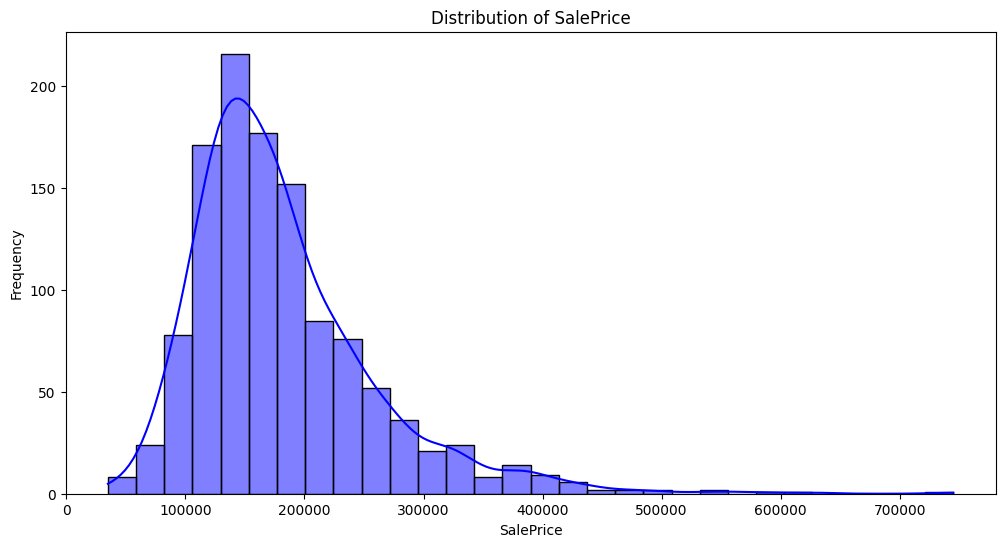

SalePrice Statistics:
Mean: 181441.5419520548
Median: 165000.0
Standard Deviation: 77263.58386222839


In [38]:
plt.figure(figsize=(12, 6))
sns.histplot(y_train, bins=30, kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

print("SalePrice Statistics:")
print(f"Mean: {y_train.mean()}")
print(f"Median: {y_train.median()}")
print(f"Standard Deviation: {y_train.std()}")

In [39]:
X_train['TotalArea'] = X_train['1stFlrSF'] + X_train['2ndFlrSF'] + X_train['TotalBsmtSF']
X_train['Age'] = X_train['YrSold'] - X_train['YearBuilt']
X_train['TotalBathrooms'] = X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']) + X_train['FullBath'] + (0.5 * X_train['HalfBath'])
X_train['Remodeled'] = (X_train['YearRemodAdd'] > X_train['YearBuilt']).astype(int)
X_train['OverallGrade'] = X_train['OverallQual'] * X_train['OverallCond']
print(X_train.columns)

X_val['TotalArea'] = X_val['1stFlrSF'] + X_val['2ndFlrSF'] + X_val['TotalBsmtSF']
X_val['Age'] = X_val['YrSold'] - X_val['YearBuilt']
X_val['TotalBathrooms'] = X_val['BsmtFullBath'] + (0.5 * X_val['BsmtHalfBath']) + X_val['FullBath'] + (0.5 * X_val['HalfBath'])
X_val['Remodeled'] = (X_val['YearRemodAdd'] > X_val['YearBuilt']).astype(int)
X_val['OverallGrade'] = X_val['OverallQual'] * X_val['OverallCond']


test['TotalArea'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']
test['Age'] = test['YrSold'] - test['YearBuilt']
test['TotalBathrooms'] = test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']) + test['FullBath'] + (0.5 * test['HalfBath'])
test['Remodeled'] = (test['YearRemodAdd'] > test['YearBuilt']).astype(int)
test['OverallGrade'] = test['OverallQual'] * test['OverallCond']

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

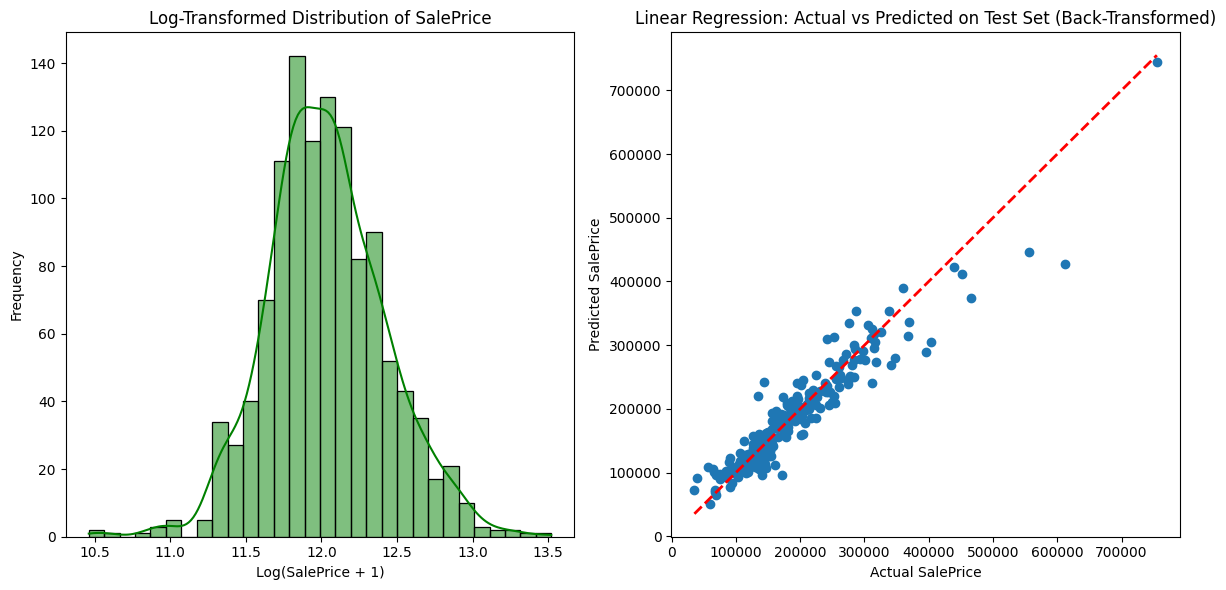

R-squared on the test set (Linear Regression): 0.8992791943864247
Mean Squared Error on the test set (Linear Regression): 772561434.9068071


In [40]:
y_train_log = np.log1p(y_train)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train_log, bins=30, kde=True, color='green')
plt.title('Log-Transformed Distribution of SalePrice')
plt.xlabel('Log(SalePrice + 1)')
plt.ylabel('Frequency')

linear_model = LinearRegression()
linear_model.fit(X_train, y_train_log)

predictions_test_linear = linear_model.predict(X_val)

plt.subplot(1, 2, 2)
plt.scatter(y_val, np.expm1(predictions_test_linear))
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted on Test Set (Back-Transformed)')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

plt.tight_layout()
plt.show()

predictions_test_linear_back_transformed = np.expm1(predictions_test_linear)
r_squared_test_linear = r2_score(y_val, predictions_test_linear_back_transformed)
mse_test_linear = mean_squared_error(y_val, predictions_test_linear_back_transformed)

print(f'R-squared on the test set (Linear Regression): {r_squared_test_linear}')
print(f'Mean Squared Error on the test set (Linear Regression): {mse_test_linear}')

<ipython-input-41-c177ad106cdc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_continuous.index, y=correlation_continuous.values, palette = 'viridis')


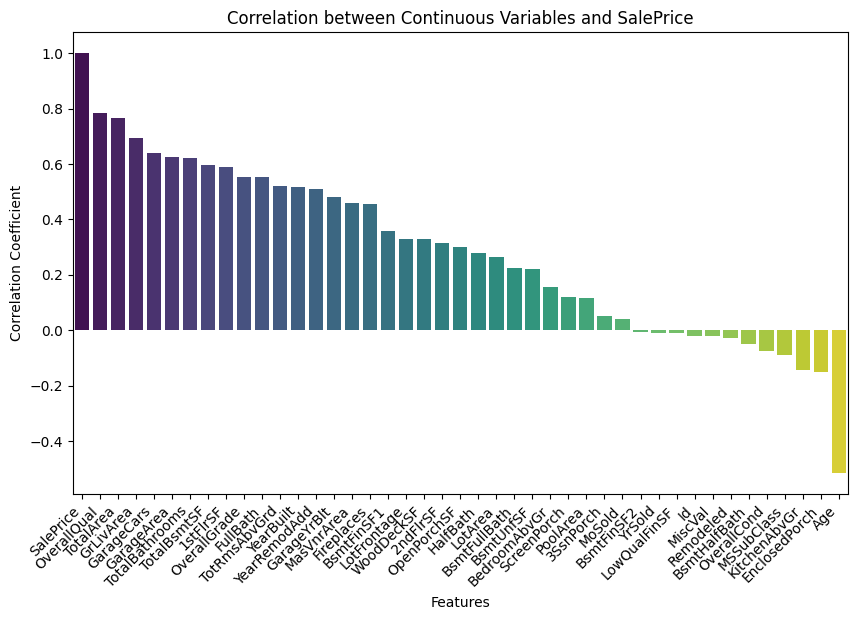

In [41]:
continuous_features['TotalArea'] = continuous_features['1stFlrSF'] + continuous_features['2ndFlrSF'] + continuous_features['TotalBsmtSF']
continuous_features['Age'] = continuous_features['YrSold'] - continuous_features['YearBuilt']
continuous_features['TotalBathrooms'] = continuous_features['BsmtFullBath'] + (0.5 * continuous_features['BsmtHalfBath']) + continuous_features['FullBath'] + (0.5 * continuous_features['HalfBath'])
continuous_features['Remodeled'] = (continuous_features['YearRemodAdd'] > continuous_features['YearBuilt']).astype(int)
continuous_features['OverallGrade'] = continuous_features['OverallQual'] * continuous_features['OverallCond']

correlation_continuous = continuous_features.apply(lambda x: x.corr(y_train))
correlation_continuous = correlation_continuous.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_continuous.index, y=correlation_continuous.values, palette = 'viridis')
plt.title('Correlation between Continuous Variables and SalePrice')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-42-78e07f54941f>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2_Stat', y='Feature', data=chi2_results_categorical, palette='viridis', order=chi2_results_categorical['Feature'])


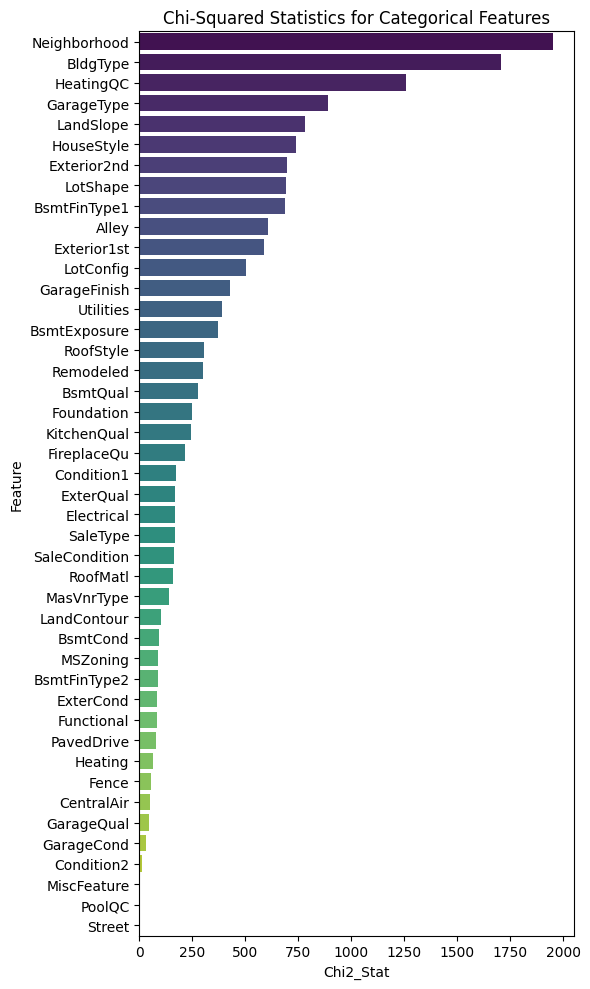

In [42]:
from sklearn.feature_selection import chi2
import pandas as pd

categorical_features['Remodeled'] = (X_train['YearRemodAdd'] > X_train['YearBuilt']).astype(int)

chi2_stat, p_values = chi2(X_train, y_train)

chi2_results = pd.DataFrame({'Feature': X_train.columns, 'Chi2_Stat': chi2_stat, 'P_Value': p_values})

chi2_results_categorical = chi2_results[chi2_results['Feature'].isin(categorical_features)]

chi2_results_categorical = chi2_results_categorical.sort_values(by='Chi2_Stat', ascending=False)
plt.figure(figsize=(6, 10))
sns.barplot(x='Chi2_Stat', y='Feature', data=chi2_results_categorical, palette='viridis', order=chi2_results_categorical['Feature'])

plt.title('Chi-Squared Statistics for Categorical Features')
plt.tight_layout()

plt.show()

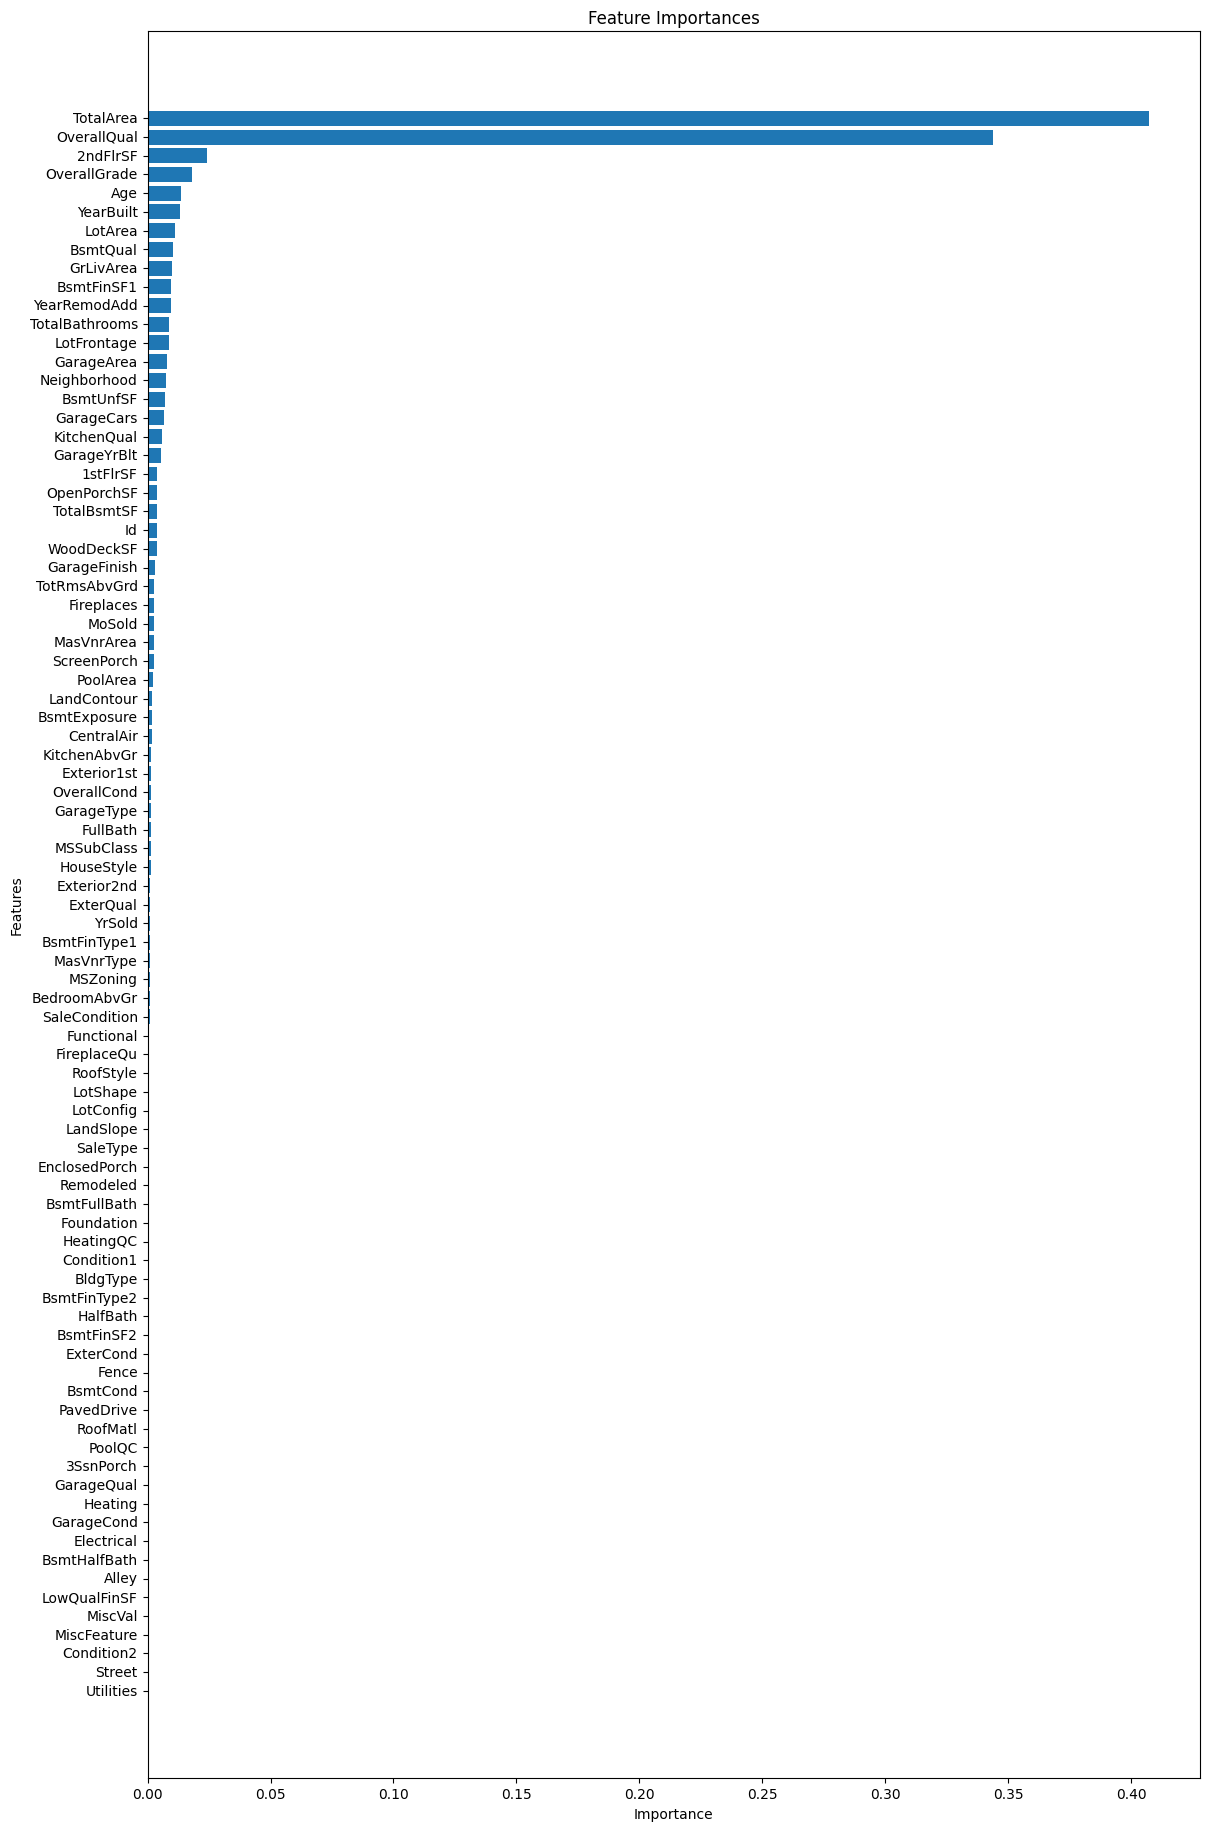

In [43]:
features = X_train.columns.tolist()
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

f_i = list(zip(features, rf.feature_importances_))
f_i.sort(key=lambda x: x[1])

plt.figure(figsize=(12, 18))

bar_plot = plt.barh([x[0] for x in f_i], [x[1] for x in f_i])

plt.yticks(ha='right', va='center')

tick_positions = range(len(f_i))
plt.yticks(tick_positions, [f_i[i][0] for i in tick_positions])

plt.tight_layout()

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()


# Feature Selection

(1168, 85)
(1168,)


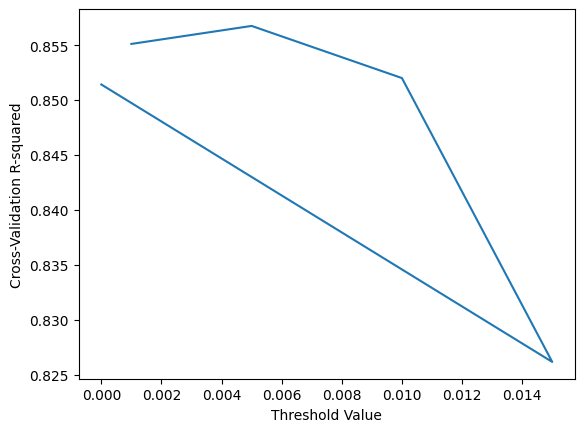

Best threshold value: 0.005


In [44]:
print(np.shape(X_train))
print(np.shape(y_train))

rf = RandomForestRegressor(random_state=478)

threshold_values = [0.001, 0.005, 0.01, 0.015, 0.]
cv_scores = []

for threshold_value in threshold_values:
    sfm = SelectFromModel(rf, threshold=threshold_value)
    X_train_selected = sfm.fit_transform(X_train, y_train)

    scores = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='r2')
    cv_scores.append(np.mean(scores))

plt.plot(threshold_values, cv_scores)
plt.xlabel('Threshold Value')
plt.ylabel('Cross-Validation R-squared')
plt.show()


best_threshold_value = threshold_values[np.argmax(cv_scores)]
print(f"Best threshold value: {best_threshold_value}")



In [45]:
sfm = SelectFromModel(rf, threshold=best_threshold_value)

X_train_selected = sfm.fit_transform(X_train, y_train)
rf.fit(X_train_selected, y_train)

X_val_selected = sfm.transform(X_val)

predictions_val = rf.predict(X_val_selected)

r_squared_val = r2_score(y_val, predictions_val)
mse_val = mean_squared_error(y_val, predictions_val)

print(f'R-squared on the validation set: {r_squared_val}')
print(f'Mean Squared Error on the validation set: {mse_val}')

R-squared on the validation set: 0.9012410752208795
Mean Squared Error on the validation set: 757513168.9269098


Selected features: Index(['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'BsmtQual', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF',
       'GrLivArea', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalArea',
       'Age', 'TotalBathrooms', 'OverallGrade'],
      dtype='object')
(18,)


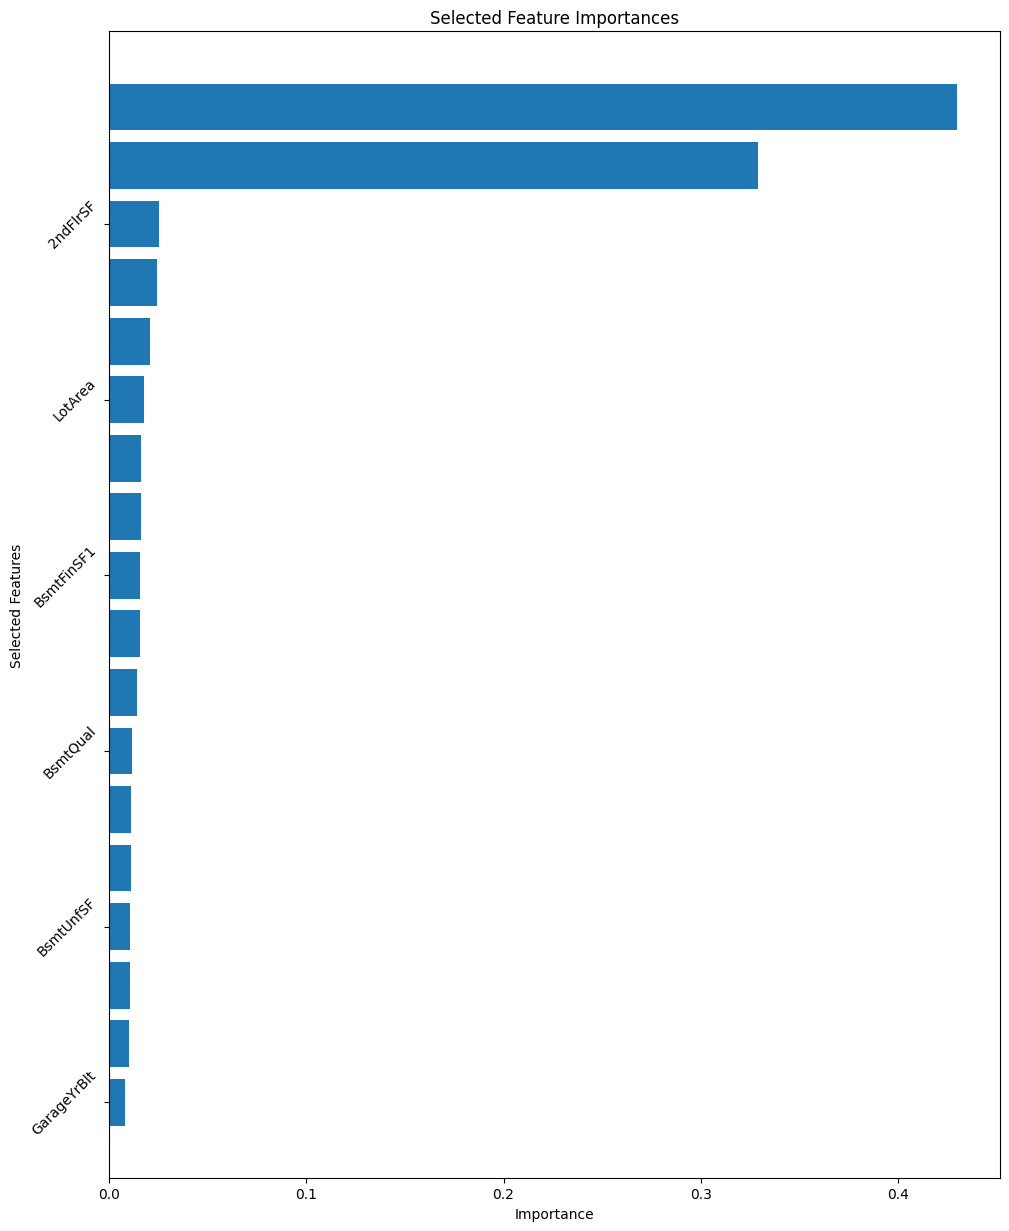

In [46]:
selected_feature_indices = sfm.get_support(indices=True)

selected_features = X_train.columns[selected_feature_indices]
print(f"Selected features: {selected_features}")
print(np.shape(selected_features))

f_i = list(zip(selected_features, rf.feature_importances_))
f_i.sort(key=lambda x: x[1])

plt.figure(figsize=(10, 12))

bar_plot = plt.barh([x[0] for x in f_i], [x[1] for x in f_i])

plt.yticks(rotation=45, ha='right', va='center')

tick_positions = range(0, len(f_i), 3)
plt.yticks(tick_positions, [f_i[i][0] for i in tick_positions])

plt.tight_layout()

plt.title('Selected Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Selected Features')

plt.show()


In [47]:
X_train_selected = sfm.fit_transform(X_train, y_train)
rf.fit(X_train_selected, y_train)

test['TotalArea'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']
test['Age'] = test['YrSold'] - test['YearBuilt']
test['TotalBathrooms'] = test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']) + test['FullBath'] + (0.5 * test['HalfBath'])
test['Remodeled'] = (test['YearRemodAdd'] > test['YearBuilt']).astype(int)
test['OverallGrade'] = test['OverallQual'] * test['OverallCond']

X_test_selected = sfm.transform(test)
predictions_test = rf.predict(X_test_selected)
test_id = test['Id']
output_df = pd.DataFrame({'Id': test_id, 'Predictions': predictions_test})
#output_df.to_excel('predictions_test.xlsx', index=False)

R-squared on the training set (Decision Tree): 0.9999916899786337
Root Mean Squared Error on the training set (Decision Tree): 222.633198548398
R-squared on the validation set (Decision Tree): 0.7953831996390037
Root Mean Squared Error on the validation set (Decision Tree): 39616.63294930207


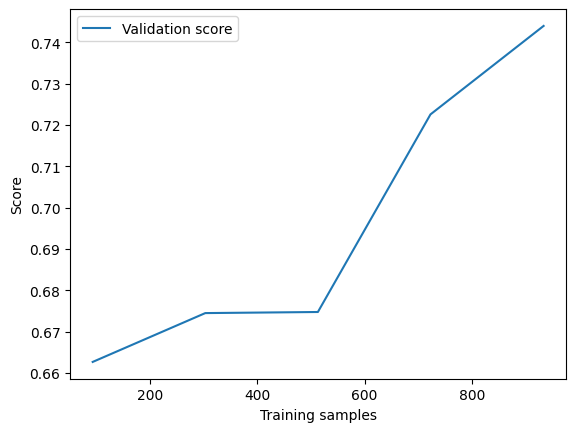

In [52]:
# decision tree
model = DecisionTreeRegressor()
model.fit(X_train_selected, y_train)

predictions_train = model.predict(X_train_selected)

r_squared_train = r2_score(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train, squared=False)

print(f'R-squared on the training set (Decision Tree): {r_squared_train}')
print(f'Root Mean Squared Error on the training set (Decision Tree): {rmse_train}')

predictions_val = model.predict(X_val_selected)

r_squared_val = r2_score(y_val, predictions_val)
rmse_val = mean_squared_error(y_val, predictions_val, squared=False)
print(f'R-squared on the validation set (Decision Tree): {r_squared_val}')
print(f'Root Mean Squared Error on the validation set (Decision Tree): {rmse_val}')


train_sizes, train_scores, val_scores = learning_curve(model, X_train_selected, y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.xlabel('Training samples')
plt.ylabel('Score')
plt.legend()
plt.show()


In [53]:
# bagging
bagging_model = BaggingRegressor(model, random_state=478)

param_grid = {
    'n_estimators': [80, 120, 200],
    'base_estimator__max_depth': [None, 5, 10],
    'max_samples': [0.7, 0.9, 1],
    'oob_score': [True, False],
}

scoring = {'r2': 'r2'}
grid = GridSearchCV(estimator=bagging_model, param_grid=param_grid, scoring=scoring, cv=3, refit='r2')

grid_result = grid.fit(X_train_selected, y_train)

print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"Best R-squared: {grid_result.cv_results_['mean_test_r2'][grid_result.best_index_]}")

best_bagging_model = grid_result.best_estimator_
predictions_val = best_bagging_model.predict(X_val_selected)

rmse_val = mean_squared_error(y_val, predictions_val, squared=False)
r_squared_val = r2_score(y_val, predictions_val)

print(f'Root Mean Squared Error on the validation set (Best Bagging Model): {rmse_val}')
print(f'R-squared on the validation set (Best Bagging Model): {r_squared_val}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator

Best Hyperparameters: {'base_estimator__max_depth': None, 'max_samples': 0.9, 'n_estimators': 200, 'oob_score': True}
Best R-squared: 0.8747337597816792
Mean Squared Error on the validation set (Best Bagging Model): 27763.541397521563
R-squared on the validation set (Best Bagging Model): 0.899506981826974


In [50]:
# svr
svr_model = make_pipeline(StandardScaler(), SVR())

param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [10000, 100000, 100500],
    'svr__epsilon': [0.1, 0.2, 0.3]
}

scoring = {
    'r2': make_scorer(r2_score)
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, scoring=scoring, cv=3, refit='r2')

grid_search.fit(X_train_selected, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R-squared: {grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]}")

best_svr_model = grid_search.best_estimator_
predictions_val = best_svr_model.predict(X_val_selected)

rmse_val = mean_squared_error(y_val, predictions_val, squared=False)
r_squared_val = r2_score(y_val, predictions_val)

print(f'Root Mean Squared Error on the validation set (Best SVR Model): {rmse_val}')
print(f'R-squared on the validation set (Best SVR Model): {r_squared_val}')

Best Hyperparameters: {'svr__C': 100500, 'svr__epsilon': 0.3, 'svr__kernel': 'rbf'}
Best R-squared: 0.8427279707827636
Mean Squared Error on the validation set (Best SVR Model): 1141550449.217758
R-squared on the validation set (Best SVR Model): 0.8511731550415521


In [54]:
# random forest
from sklearn.ensemble import RandomForestRegressor

base_model = RandomForestRegressor(random_state=42)
rf_model = make_pipeline(StandardScaler(), base_model)

param_grid = {
    'randomforestregressor__n_estimators': [10, 20, 30],
    'randomforestregressor__max_depth': [None, 5, 10],
    'randomforestregressor__min_samples_split': [2, 5, 10]
}

scoring = {
    'r2': 'r2'
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, cv=3, refit='r2')

grid_search.fit(X_train_selected, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R-squared: {grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]}")

best_rf_model = grid_search.best_estimator_
predictions_val = best_rf_model.predict(X_val_selected)

rmse_val = mean_squared_error(y_val, predictions_val, squared=False)
r_squared_val = r2_score(y_val, predictions_val)

print(f'Root Mean Squared Error on the validation set (Best Random Forest Model): {rmse_val}')
print(f'R-squared on the validation set (Best Random Forest Model): {r_squared_val}')

Best Hyperparameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 30}
Best R-squared: 0.8693818469905539
Root Mean Squared Error on the validation set (Best Random Forest Model): 28567.053391535526
R-squared on the validation set (Best Random Forest Model): 0.8936060191664111


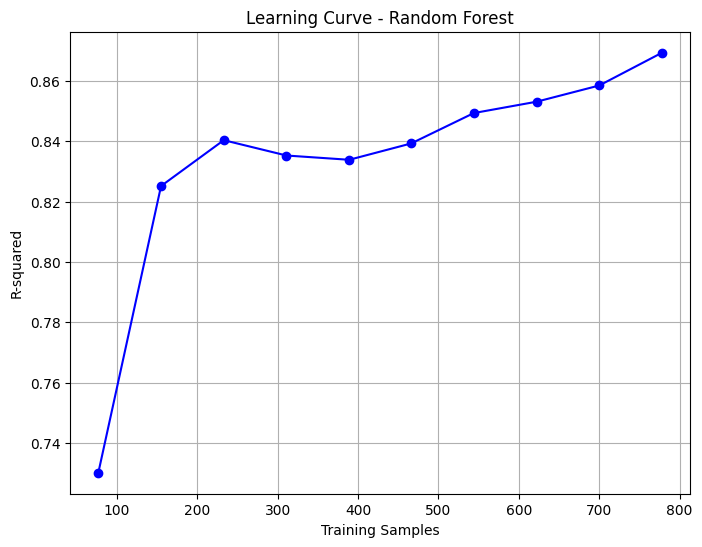

In [56]:
# random forest learning curve
from sklearn.model_selection import learning_curve

base_model = RandomForestRegressor(random_state=42)

rf_model = make_pipeline(StandardScaler(), base_model)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, _, test_scores = learning_curve(rf_model, X_train_selected, y_train, train_sizes=train_sizes, cv=3, scoring='r2')

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Samples")
plt.ylabel("R-squared")
plt.grid()

plt.plot(train_sizes, test_scores_mean, 'o-', color="b")

plt.show()

In [55]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

base_model = GradientBoostingRegressor(random_state=42)
g_boost_model = make_pipeline(StandardScaler(), base_model)

param_grid = {
    'gradientboostingregressor__n_estimators': [10, 20, 30],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.3],
    'gradientboostingregressor__max_depth': [3, 5, 7]
}

scoring = {
    'r2': 'r2'
}

grid_search = GridSearchCV(estimator=g_boost_model, param_grid=param_grid, scoring=scoring, cv=3, refit='r2')

grid_search.fit(X_train_selected, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R-squared: {grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]}")

best_g_boost_model = grid_search.best_estimator_
predictions_val = best_g_boost_model.predict(X_val_selected)

rmse_val = mean_squared_error(y_val, predictions_val, squared=False)
r_squared_val = r2_score(y_val, predictions_val)

print(f'Mean Squared Error on the validation set (Best Gradient Boosting Model): {rmse_val}')
print(f'R-squared on the validation set (Best Gradient Boosting Model): {r_squared_val}')

Best Hyperparameters: {'gradientboostingregressor__learning_rate': 0.3, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 30}
Best R-squared: 0.8823976943282269
Mean Squared Error on the validation set (Best Gradient Boosting Model): 26565.030208169504
R-squared on the validation set (Best Gradient Boosting Model): 0.9079959820614


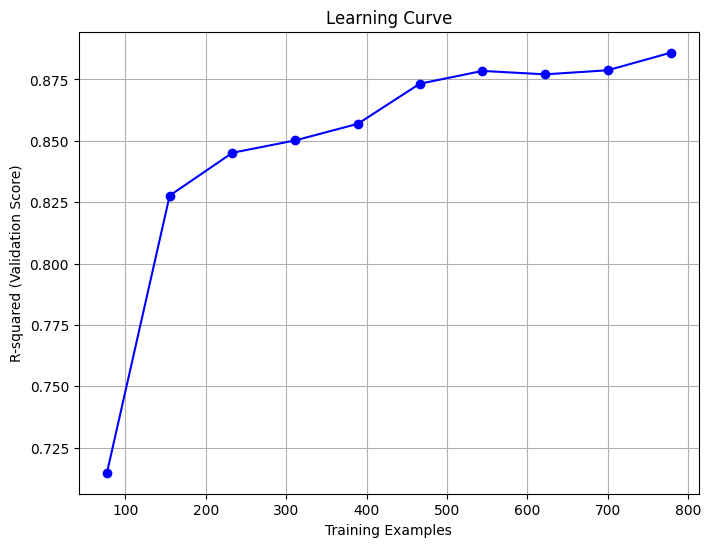

In [58]:
# gradient boosting learning curve
from sklearn.model_selection import learning_curve

base_model = GradientBoostingRegressor(random_state=42)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, _, test_scores = learning_curve(base_model, X_train_selected, y_train, train_sizes=train_sizes, cv=3, scoring='r2')

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("R-squared (Validation Score)")
plt.grid()

plt.plot(train_sizes, test_scores_mean, 'o-', color="b")

plt.show()